# The Business Challenge


## The Blocker Fraud Company

- Financial transactions' fraud detection specialized company.
- The Blocker Fraud service ensures fraudulent transactions block.
- Business Model: service's performance monetization.

### Expansion Strategy in Brazil

1. The company receives 25% of each transaction value truly detected as fraud.
2. The company receives 5% of each transaction value detected as fraud, however the transaction is legitimate.
3. The company gives back 100% of the value for the customer in each transaction detected as legitimate, however the transaction is actually a fraud.

### Goal

- Create a model with high accuracy and precision with respect to transactions' fraud detection.

### Deliverables

- Deployed model with API access. The API must inform "Fraud" or "Legitimate" when the transaction is inputed.


- A Readme about how to use the tool.


- Model performance and results report with respect to profit and loss. The following questions must be answered:

     - What is the model's precision and accuracy?
     - What is the model's reliability with respect to transactions' classification as legitimate or fraudulent?
     - What is the company's forecasted revenue if the model classifies 100% of the transactions?
     - What is the company's forecasted loss in case of model's failure?
     - What is the Blocker Fraud Company forecasted profit using the model?

###  Consequences of Financial Fraud

 First, serving as a **signal of dishonesty**, financial fraud makes customers and suppliers cast doubt on a firm’s commitments in the product market, which will weaken the incentives for customers and suppliers to sign contracts with the company. Second, financial fraud directly **affects a firm’s financing abilities and financing costs**, as well as the adjustments of corporate governance (such as the departure of executives). This leads to great difficulties and uncertainties in a company’s production and operation activities. Thus, it is impossible for fraud firms to fulfil their existing commitments (or future commitments) (Cornell & Shapiro, 1987).
 
 According to Infosecurity Magazine, **fraud cost the global economy £3.2 trillion in 2018**. For some businesses, losses to fraud reach more than 10% of their total spending. Such massive losses push companies to search for new solutions to prevent, detect, and eliminate fraud.

<img src= "../data/fraud_losses.png">

Fraud can have a devastating impact on a business. In 2001, a **massive corporate fraud** was uncovered at Enron, a U.S.-based energy company. Executives used a variety of techniques to disguise the company’s financial health, including the deliberate obfuscation of revenue and misrepresentation of earnings. After the fraud was uncovered, shareholders saw share prices plummet from around $90 to less than $1 in a little over a year. Company employees had their equity wiped out and lost their jobs after Enron declared bankruptcy. The Enron scandal was a major driver behind the regulations found in the **Sarbanes-Oxley Act** passed in 2002.

Compared with the control firms, firms engaging in financial fraud exhibit a **decline in sales revenue** by 11.9–17.1% and a **decrease in their gross profit margi** on sales by 2.4–2.8% in the three years after punishment. Furthermore, sales revenue from the top five large customers falls 43.9–55.1% in the post-punishment period, while sales revenue from small customers does not decline significantly.

# 0.0 Imports

In [1]:
# utilities
import pickle
from IPython.display import HTML
from collections import Counter

# data manipulation
import pandas as pd
import numpy as np
from sklearn.utils import shuffle

# PySpark for data manipulation
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.types import StructField, StringType, ShortType, DoubleType, StructType, IntegerType
from pyspark.sql.functions import format_number, skewness, kurtosis, col, when, isnan, count
from pyspark.sql import DataFrame as SparkDataFrame
import pyspark.pandas as ps
from pyspark.pandas import read_csv
import pyspark.sql.functions as f


# text edit
import inflection

# EDA
import matplotlib.pyplot as plt
import seaborn as sns
#from pandas_profiling import ProfileReport
from IPython.display import IFrame

# preprocessing
from sklearn.preprocessing import MinMaxScaler

# feature selection
from boruta import BorutaPy

# machine learning
from sklearn.model_selection import train_test_split

# algorithms
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# models' cross-validation
from sklearn.model_selection import cross_validate, cross_val_score, cross_val_predict, RandomizedSearchCV

# model evaluation and metrics
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import brier_score_loss, classification_report, roc_curve

# model calibration
from sklearn.calibration import CalibratedClassifierCV, calibration_curve

 # apply stratified sampling
from sklearn.model_selection import StratifiedShuffleSplit

# warning
import warnings
warnings.filterwarnings( 'ignore' )

/home/felipepedrosa/.conda/envs/blocker_fraud/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


# 0.1 Helper Functions

In [2]:
def my_settings():
    %matplotlib inline
    
    # plotly settings
    plt.style.use( 'ggplot' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 8
    
    # sets global SEED
    SEED = 42
 
    # notebook settings
    display(HTML('<style>.container{width:100% !important;}</style>'))
    np.set_printoptions(suppress=True)
    pd.set_option('display.float_format', '{:.3f}'.format)
    
    # seaborn settings
    sns.set(rc={'figure.figsize':(25,12)})
    sns.set_theme(style = 'darkgrid', font_scale = 1)
my_settings()

In [3]:
def renameCols(df, old_columns, new_columns):
    for old_col,new_col in zip(old_columns,new_columns):
        df = df.withColumnRenamed(old_col,new_col)
    return df

In [4]:
 # Descriptive Statistics function
# valid only for numerical attriubutes
def num_stats(num_attr):
    # Central Tendency - mean, median
    ct1 = pd.DataFrame( num_attr.apply( np.mean ) ).T
    ct2 = pd.DataFrame( num_attr.apply( np.median ) ).T

    # Dispersion - standard deviation (std), min, max, skew, kurtosis
    d1 = pd.DataFrame( num_attr.apply( np.std ) ).T
    d2 = pd.DataFrame( num_attr.apply( min ) ).T
    d3 = pd.DataFrame( num_attr.apply( max ) ).T

    # Dispersion - values' Range
    d4 = pd.DataFrame( num_attr.apply( lambda x: x.max() - x.min() ) ).T

    # Dispersion - skew and kurtosis
    d5 = pd.DataFrame( num_attr.apply( lambda x: x.skew() ) ).T
    d6 = pd.DataFrame( num_attr.apply( lambda x: x.kurtosis() ) ).T

    # Concatenate all data frames
    m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
    m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
    
    # histogram
    num_hist = num_attr.hist( bins=25, figsize=(20,15) );

    # display dataframe
    return m
    
    # display histogram
    return num_hist

In [5]:
# point biserial correlation coefficient heatmap function
def point_bi_corr(a, b):
    # a: input dataframe with binary variable
    # b: input dataframe with continuous variable
    
    # get column name
    a_name = a.columns[0]
    b_name = b.columns[0]
    
    # transform dataframe to array
    a = a.values.reshape(-1)
    b = b.values.reshape(-1)
    
    # apply scipy's point-biserial
    stats.pointbiserialr(a, b)
    
    # correlation coefficient array
    c = np.corrcoef(a,b)
    
    # dataframe for heatmap
    df = pd.DataFrame(c, columns=[a_name, b_name], index=[a_name, b_name])
    
    # return heatmap
    return sns.heatmap(df, annot=True).set_title('{} x {} correlation heatmap'.format(a_name, b_name));

In [6]:
# Model's performance function
def performance(model, x_train, y_train):
    # define scoring metrics
    scoring = {'accuracy': 'accuracy',
               'precision': make_scorer(precision_score),
               'recall': make_scorer(recall_score),
               'f1_score': make_scorer(f1_score),
               'roc_auc_score': make_scorer(roc_auc_score),
               'mcc': make_scorer(matthews_corrcoef)}

    # calculate scores with cross_validate
    scores = cross_validate(model, x_train, y_train, cv=10, scoring=scoring)

    # performance data frame
    performance = pd.DataFrame.from_dict(scores).drop(['fit_time', 'score_time'], axis=1)
    performance = pd.DataFrame(performance.mean()).T
    return performance

In [7]:
# Fine-tuned Model's performance function
def fine_tuned_performance(model, x_train, y_train):
    # define scoring metrics
    scoring = {'accuracy': 'accuracy',
               'precision': make_scorer(precision_score),
               'recall': make_scorer(recall_score),
               'f1_score': make_scorer(f1_score),
               'roc_auc_score': make_scorer(roc_auc_score),
               'mcc': make_scorer(matthews_corrcoef)}

    # calculate scores with cross_validate
    scores = cross_validate(model, x_train, y_train, cv=10, scoring=scoring)

    # performance data frame
    performance = pd.DataFrame.from_dict(scores).drop(['fit_time', 'score_time'], axis=1)
    performance = pd.DataFrame(np.round(performance.mean(), 4).astype(str) + '+/-' + np.round(performance.std()*2,4).astype(str)).T
    return performance

In [8]:

def train_test_split_pyspark(
    df: SparkDataFrame,
    startify_column: str,
    unique_col: str = None,
    train_fraction: float = 0.7,
    validation_fraction: float = 0.1,
    test_fraction: float = 0.2,
    seed: int = 1234,
    to_pandas: bool = True,
):
    if not unique_col:
        unique_col = "any_unique_name_here"
        df = df.withColumn(unique_col, f.monotonically_increasing_id())

    # Train data
    train_fraction_dict = (
        df.select(startify_column)
        .distinct()
        .withColumn("fraction", f.lit(train_fraction))
        .rdd.collectAsMap()
    )
    df_train = df.stat.sampleBy(startify_column, train_fraction_dict, seed)
    df_remaining = df.join(df_train, on=unique_col, how="left_anti")

    # Validation data
    validation_fraction_dict = {
        key: validation_fraction for (_, key) in enumerate(train_fraction_dict)
    }
    df_val = df_remaining.stat.sampleBy(startify_column, validation_fraction_dict, seed)
    df_remaining = df_remaining.join(df_val, on=unique_col, how="left_anti")

    # Test data
    test_fraction_dict = {
        key: test_fraction for (_, key) in enumerate(train_fraction_dict)
    }
    df_test = df_remaining.stat.sampleBy(startify_column, test_fraction_dict, seed)

    if unique_col == "any_unique_name_here":
        df_train = df_train.drop(unique_col)
        df_val = df_val.drop(unique_col)
        df_test = df_test.drop(unique_col)

    if to_pandas:
        return (df_train.toPandas(), df_val.toPandas(), df_test.toPandas())
    return df_train, df_val, df_test

## Create a SparkSession

In [9]:
# creates a SparkSession
spark = SparkSession.builder\
        .appName('Fraud')\
        .getOrCreate()

# Enable Arrow-based columnar data transfers
spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", "true")

# customizes the output fontsize
display(HTML('''<style>[data-mime-type="application/vnd.jupyter.stdout"] pre { font-size:14px}</style>'''))

22/09/12 15:25:30 WARN Utils: Your hostname, Felipe_Pedrosa resolves to a loopback address: 127.0.1.1; using 172.24.46.242 instead (on interface eth0)
22/09/12 15:25:30 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/09/12 15:25:32 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [10]:
print('My pyspark version is %s' %pyspark.__version__)

My pyspark version is 3.3.0


In [11]:
spark

# 0.2 Loading Data

 Source data set: https://www.kaggle.com/ntnu-testimon/paysim1

## 0.2.1 Specifying dtypes for Spark DataFrame when reading from csv

In [12]:
# defines the schema: field, type, nullabe or not
data_schema = [StructField('step', ShortType(), True), 
               StructField('type', StringType(), True),
               StructField('amount', DoubleType(), True),
               StructField('nameOrig', StringType(), True),
               StructField('oldbalanceOrg', DoubleType(), True),
               StructField('newbalanceOrig', DoubleType(), True),
               StructField('nameDest', StringType(), True),
               StructField('oldbalanceDest', DoubleType(), True),
               StructField('newbalanceDest', DoubleType(), True),
               StructField('isFraud', ShortType(), True),
               StructField('isFlaggedFraud', ShortType(), True)]

# defines the final struct
final_struct = StructType(fields=data_schema)

In [13]:
# loads data set in spark
df_fraud_spark = spark.read.csv(r'../data/raw/PS_20174392719_1491204439457_log.csv', schema=final_struct, header=True)

In [14]:
spark.conf.set('spark.sql.repl.eagerEval.enabled', True)


In [15]:
df_fraud_spark.show()

+----+--------+---------+-----------+-------------+--------------+-----------+--------------+--------------+-------+--------------+
|step|    type|   amount|   nameOrig|oldbalanceOrg|newbalanceOrig|   nameDest|oldbalanceDest|newbalanceDest|isFraud|isFlaggedFraud|
+----+--------+---------+-----------+-------------+--------------+-----------+--------------+--------------+-------+--------------+
|   1| PAYMENT|  9839.64|C1231006815|     170136.0|     160296.36|M1979787155|           0.0|           0.0|      0|             0|
|   1| PAYMENT|  1864.28|C1666544295|      21249.0|      19384.72|M2044282225|           0.0|           0.0|      0|             0|
|   1|TRANSFER|    181.0|C1305486145|        181.0|           0.0| C553264065|           0.0|           0.0|      1|             0|
|   1|CASH_OUT|    181.0| C840083671|        181.0|           0.0|  C38997010|       21182.0|           0.0|      1|             0|
|   1| PAYMENT| 11668.14|C2048537720|      41554.0|      29885.86|M123070170

In [16]:
row = df_fraud_spark.count()
print('This dataset is: {} rows'.format(row))

This dataset is: 6362620 rows


- The dataset has more than 6 million entries;

In [17]:
 # displays the schema to check dtypes
df_fraud_spark.printSchema()

root
 |-- step: short (nullable = true)
 |-- type: string (nullable = true)
 |-- amount: double (nullable = true)
 |-- nameOrig: string (nullable = true)
 |-- oldbalanceOrg: double (nullable = true)
 |-- newbalanceOrig: double (nullable = true)
 |-- nameDest: string (nullable = true)
 |-- oldbalanceDest: double (nullable = true)
 |-- newbalanceDest: double (nullable = true)
 |-- isFraud: short (nullable = true)
 |-- isFlaggedFraud: short (nullable = true)



## 0.3. Split data into Train and Test set

In [18]:
df_train, df_val, df_test = train_test_split_pyspark(df=df_fraud_spark, startify_column='isFraud')

In [19]:
df_val

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,CASH_IN,269736.990,C540092563,9630666.580,9900403.570,C1526298704,473512.630,32092.070,0,0
1,1,PAYMENT,2147.210,C202064342,101336.000,99188.790,M1211586911,0.000,0.000,0,0
2,1,PAYMENT,909.330,C1627781283,67210.020,66300.680,M574077658,0.000,0.000,0,0
3,1,PAYMENT,911.270,C1095203437,25688.810,24777.540,M45880026,0.000,0.000,0,0
4,1,CASH_OUT,216007.530,C918307166,1024825.540,808818.010,C401424608,1602701.930,1178808.140,0,0
...,...,...,...,...,...,...,...,...,...,...,...
190727,715,PAYMENT,8301.340,C768672563,11330.000,3028.660,M390138585,0.000,0.000,0,0
190728,715,CASH_OUT,252516.990,C1474155846,52271.000,0.000,C2104221637,41550.750,294067.730,0,0
190729,715,CASH_OUT,304075.170,C1077758017,282.000,0.000,C514280663,1160262.840,1464338.020,0,0
190730,718,PAYMENT,7808.400,C1258101709,7144.000,0.000,M1230239274,0.000,0.000,0,0


In [20]:
df_train

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,TRANSFER,181.000,C1305486145,181.000,0.000,C553264065,0.000,0.000,1,0
1,1,CASH_OUT,181.000,C840083671,181.000,0.000,C38997010,21182.000,0.000,1,0
2,1,PAYMENT,7817.710,C90045638,53860.000,46042.290,M573487274,0.000,0.000,0,0
3,1,PAYMENT,7107.770,C154988899,183195.000,176087.230,M408069119,0.000,0.000,0,0
4,1,PAYMENT,7861.640,C1912850431,176087.230,168225.590,M633326333,0.000,0.000,0,0
...,...,...,...,...,...,...,...,...,...,...,...
4453582,743,TRANSFER,1258818.820,C1531301470,1258818.820,0.000,C1470998563,0.000,0.000,1,0
4453583,743,CASH_OUT,1258818.820,C1436118706,1258818.820,0.000,C1240760502,503464.500,1762283.330,1,0
4453584,743,CASH_OUT,339682.130,C786484425,339682.130,0.000,C776919290,0.000,339682.130,1,0
4453585,743,TRANSFER,6311409.280,C1529008245,6311409.280,0.000,C1881841831,0.000,0.000,1,0


In [21]:
df_test

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,CASH_IN,55837.160,C713898436,4849053.050,4904890.210,C100555887,66800.820,10963.660,0,0
1,1,CASH_IN,25090.030,C864221358,6572510.820,6597600.850,C1282788025,80148.600,0.000,0,0
2,1,PAYMENT,4828.430,C247644034,36736.580,31908.140,M214313531,0.000,0.000,0,0
3,1,CASH_OUT,30308.450,C1949126165,88926.200,88926.200,C1568059495,88926.200,122750.490,0,0
4,1,PAYMENT,12491.010,C247795540,0.000,0.000,M200744172,0.000,0.000,0,0
...,...,...,...,...,...,...,...,...,...,...,...
343533,715,CASH_OUT,205836.120,C551661789,50325.000,0.000,C2073046775,0.000,205836.120,0,0
343534,715,CASH_OUT,41781.520,C571291780,20837.000,0.000,C307265065,237929.930,279711.440,0,0
343535,717,PAYMENT,13106.610,C1539090295,35969.000,22862.390,M1936548557,0.000,0.000,0,0
343536,717,CASH_IN,51872.550,C483131281,912641.000,964513.550,C1695137697,0.000,0.000,0,0


# 1.0 Data Description

- **step** - maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation).


- **type** - CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.


- **amount** - amount of the transaction in local currency.


- **nameOrig** - customer who started the transaction.


- **oldbalanceOrg** - initial balance before the transaction.


- **newbalanceOrig** - new balance after the transaction.


- **nameDest** - customer who is the recipient of the transaction.


- **oldbalanceDest** - initial balance recipient before the transaction. Note that there is not information for customers that start with M (Merchants).


- **newbalanceDest** - new balance recipient after the transaction. Note that there is not information for customers that start with M (Merchants).


- **isFraud** - This is the transactions made by the fraudulent agents inside the simulation. In this specific dataset the fraudulent behavior of the agents aims to profit by taking control or customers accounts and try to empty the funds by transferring to another account and then cashing out of the system.


- **isFlaggedFraud** - The business model aims to control massive transfers from one account to another and flags illegal attempts. An illegal attempt in this dataset is an attempt to transfer more than 200.000 in a single transaction.

In [66]:
# df1 = df_fraud_spark.alias('df1')

In [23]:
df1 = df_train.copy()

## 1.1 Rename Columns

In [24]:
cols_old = df1.columns
cols_old

Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud'],
      dtype='object')

In [25]:
 # apply snakecase to columns names
snakecase = lambda x: inflection.underscore(x)
cols_new = list(map(snakecase, cols_old))

In [26]:
df1.columns = cols_new

In [66]:
#d f1 = renameCols(df1, cols_old, cols_new)

In [28]:
df1

,step,type,amount,name_orig,oldbalance_org,newbalance_orig,name_dest,oldbalance_dest,newbalance_dest,is_fraud,is_flagged_fraud
0,1,TRANSFER,181.000,C1305486145,181.000,0.000,C553264065,0.000,0.000,1,0
1,1,CASH_OUT,181.000,C840083671,181.000,0.000,C38997010,21182.000,0.000,1,0
2,1,PAYMENT,7817.710,C90045638,53860.000,46042.290,M573487274,0.000,0.000,0,0
3,1,PAYMENT,7107.770,C154988899,183195.000,176087.230,M408069119,0.000,0.000,0,0
4,1,PAYMENT,7861.640,C1912850431,176087.230,168225.590,M633326333,0.000,0.000,0,0
...,...,...,...,...,...,...,...,...,...,...,...
4453582,743,TRANSFER,1258818.820,C1531301470,1258818.820,0.000,C1470998563,0.000,0.000,1,0
4453583,743,CASH_OUT,1258818.820,C1436118706,1258818.820,0.000,C1240760502,503464.500,1762283.330,1,0
4453584,743,CASH_OUT,339682.130,C786484425,339682.130,0.000,C776919290,0.000,339682.130,1,0
4453585,743,TRANSFER,6311409.280,C1529008245,6311409.280,0.000,C1881841831,0.000,0.000,1,0


In [29]:
df1.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4453587 entries, 0 to 4453586
Data columns (total 11 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   step              4453587 non-null  int16  
 1   type              4453587 non-null  object 
 2   amount            4453587 non-null  float64
 3   name_orig         4453587 non-null  object 
 4   oldbalance_org    4453587 non-null  float64
 5   newbalance_orig   4453587 non-null  float64
 6   name_dest         4453587 non-null  object 
 7   oldbalance_dest   4453587 non-null  float64
 8   newbalance_dest   4453587 non-null  float64
 9   is_fraud          4453587 non-null  int16  
 10  is_flagged_fraud  4453587 non-null  int16  
dtypes: float64(5), int16(3), object(3)
memory usage: 297.3+ MB


- The dataset does not have NA values.

In [30]:
#df1.show()

In [31]:
df1['is_fraud'].value_counts(normalize=True) 

0   0.999
1   0.001
Name: is_fraud, dtype: float64

In [32]:
df1['type'].value_counts(normalize=True) 

CASH_OUT   0.352
PAYMENT    0.338
CASH_IN    0.220
TRANSFER   0.084
DEBIT      0.007
Name: type, dtype: float64

- In the stratified sampled set, isFraud proportion is kept. The feature "type" has almost the same original proportion.


In [33]:
# save train set for future notebook work
df1.to_csv('../data/processed/train_set.csv', index=False)
df_val.to_csv('../data/processed/val_set.csv', index=False)
df_test.to_csv('../data/processed/test_set.csv', index=False)

In [34]:
# df1 = pd.read_csv('../data/processed/train_set.csv')

## 1.2. Data Dimension

In [35]:
print('Number of rows: {}'.format(df1.shape[0]))
print('Number of columns: {}'.format(df1.shape[1]))

Number of rows: 4453587
Number of columns: 11


## 1.3. Descriptive Statistics

### 1.3.1. Numerical Attributes

In [36]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4453587 entries, 0 to 4453586
Data columns (total 11 columns):
 #   Column            Dtype  
---  ------            -----  
 0   step              int16  
 1   type              object 
 2   amount            float64
 3   name_orig         object 
 4   oldbalance_org    float64
 5   newbalance_orig   float64
 6   name_dest         object 
 7   oldbalance_dest   float64
 8   newbalance_dest   float64
 9   is_fraud          int16  
 10  is_flagged_fraud  int16  
dtypes: float64(5), int16(3), object(3)
memory usage: 297.3+ MB


In [37]:
# select numerical attributes
num_attr = df1.select_dtypes(include=['int16', 'float64'])

In [38]:
# describe numerical attributes
num_attr.describe()

,step,amount,oldbalance_org,newbalance_orig,oldbalance_dest,newbalance_dest,is_fraud,is_flagged_fraud
count,4453587.000,4453587.000,4453587.000,4453587.000,4453587.000,4453587.000,4453587.000,4453587.000
mean,243.376,179760.758,832797.546,854051.655,1100839.682,1225126.562,0.001,0.000
std,142.359,599793.097,2886040.306,2921951.447,3414022.851,3686168.037,0.036,0.002
min,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,156.000,13382.370,0.000,0.000,0.000,0.000,0.000,0.000
50%,239.000,74824.560,14197.000,0.000,132475.250,214249.750,0.000,0.000
75%,334.000,208682.535,107222.000,144030.190,942457.885,1111399.135,0.000,0.000
max,743.000,73823490.360,59585040.370,49585040.370,356015889.350,356179278.920,1.000,1.000


**Check is_fraud and is_flagged_fraud features**

In [39]:
# check number of instances labeled as fraud
fraud = df1['is_fraud'].sum()

# calculate the percentage of fraud
fraud_per = (fraud / len(df1)) * 100

# check number of instances labeled as is_flagged_fraud
flagged = df1['is_flagged_fraud'].sum()

# calculate the percentage of is_flagged_fraud
flagged_per = (flagged / len(df1)) * 100

# dataframe to show the results
fraud_flagged_df = pd.DataFrame({'number_of_instances':[fraud, flagged], 
                                 'percentage_%':[fraud_per, flagged_per]},
                               index=['fraud', 'flagged'])
fraud_flagged_df

,number_of_instances,percentage_%
fraud,5709,0.128
flagged,11,0.000


 **Analysis:**
- Only 0.128% of the observations are labeled as fraud
- 11 instances are labeled as is_flagged_fraud. That represents only 0.00% of the instances.

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,step,1.000,743.000,742.000,243.376,239.000,142.359,0.375,0.329
1,amount,0.000,73823490.360,73823490.360,179760.758,74824.560,599793.029,29.914,1638.237
2,oldbalance_org,0.000,59585040.370,59585040.370,832797.546,14197.000,2886039.981,5.251,32.964
3,newbalance_orig,0.000,49585040.370,49585040.370,854051.655,0.000,2921951.119,5.179,32.081
4,oldbalance_dest,0.000,356015889.350,356015889.350,1100839.682,132475.250,3414022.468,20.420,998.606
5,newbalance_dest,0.000,356179278.920,356179278.920,1225126.562,214249.750,3686167.623,19.673,893.392
6,is_fraud,0.000,1.000,1.000,0.001,0.000,0.036,27.877,775.101
7,is_flagged_fraud,0.000,1.000,1.000,0.000,0.000,0.002,636.293,404867.000


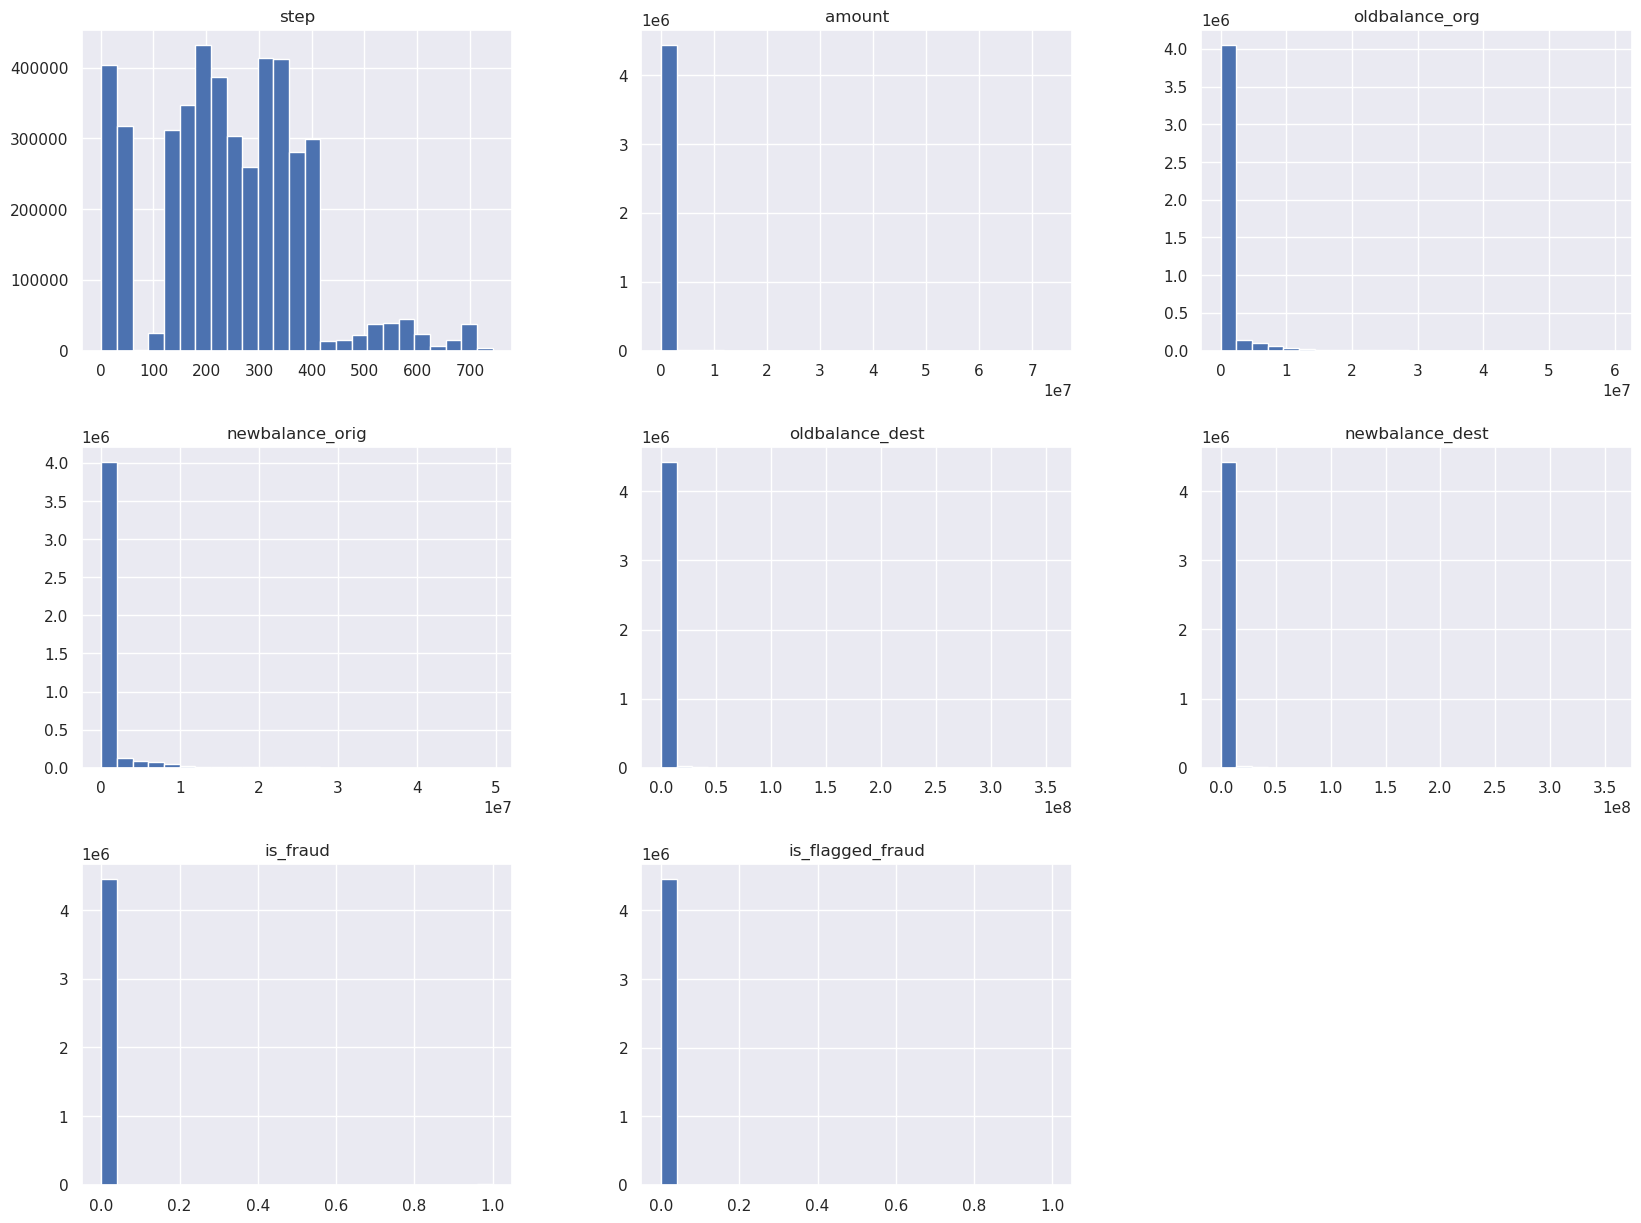

In [40]:
# apply num_stats function (see 0.1. helper function for more details)
num_stats(num_attr)

 **Descriptive Statistics Analysis:**
- None of the balances have negative numbers.
- Transaction amount ranges from 0 to more than 92 Million. Mean = 179,939. Median = 74,822. 75% of the observations are up to the value of 208,651. The minimum value is equal to zero - does it actually mean a transaction?
- The intial balance before the transaction (oldbalance_org) ranges from 0 to more than 59 Million. Mean = 834,757. Median = 14,235. 25% of the observations are equal to zero. 75% of the observations are up to the value of 107,429.
- The new balance after the transaction (newbalance_orig) ranges from 0 to more than 49 Million. Mean = 855,975. Median = 0. 50% of the observations are equal to zero. 75% of the observations are up to the value of 144,412.
- The initial balance recipient before the transaction (oldbalance_dest) ranges from 0 to more than 356 Million. Mean = 1,100,704. Median = 132,887. 25% of the observations are equal to zero. 75% of the observations are up to the value of 943,372.
- The new balance recipient after the transaction (newbalance_dest) ranges from zero to more than 356 Million. Mean = 1,225,085. Median = 214,938. 25% of the observations are equal to zero - it can be either from merchant or from fraudulent agent behaviour (cashing out of the system). 75% of the observations are up to the value of 1,112,270.

 **Histogram Analysis:**
- Between steps 50 and 75 seems that there are few / not transactions;
- After step 400 the frequency of transactions decreases significantly.
- The histograms, with exception of step feature, are not readable due to the high value range. Therefore, other types of graphs must be applied in order to check the data distribution.

#### 1.3.1.1. amount feature analysis

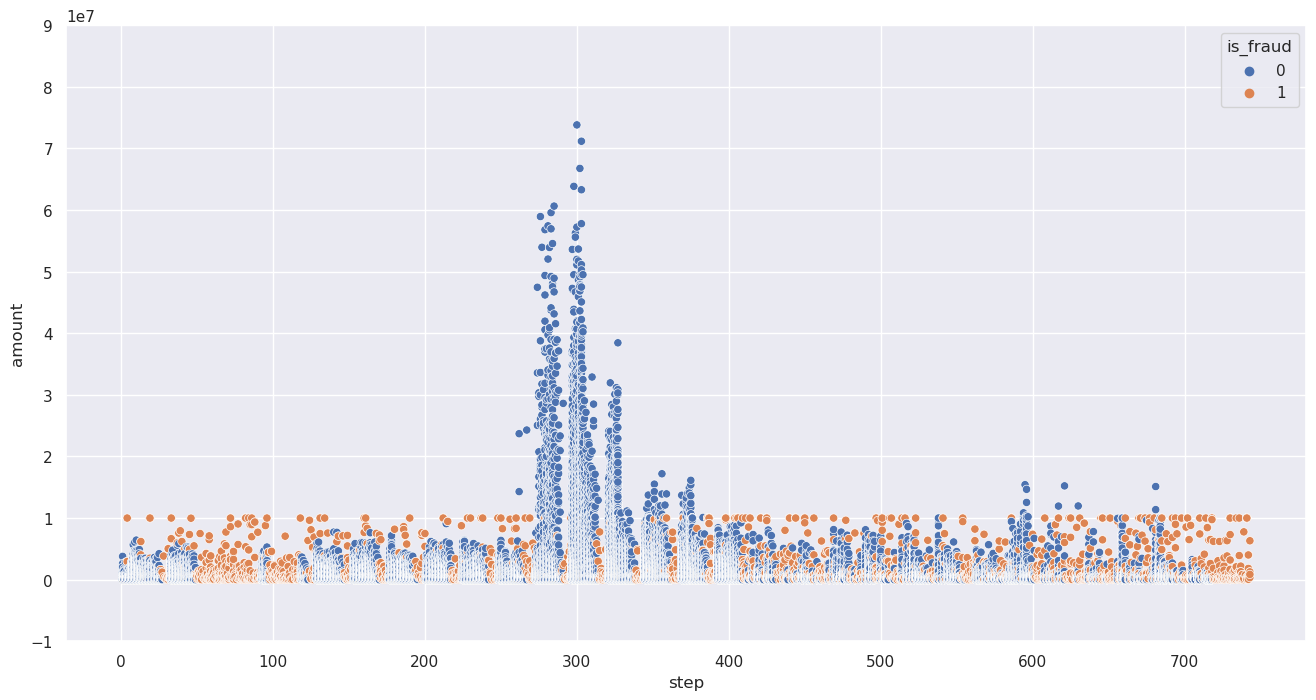

In [41]:
# plot amount scatter plot

# set up figure size
plt.subplots(figsize=(16,8))
sns.scatterplot(x='step', y='amount', hue='is_fraud', data=num_attr)

# set y-axis labels
plt.yticks(np.arange(-1.e+07, 1.e+08, step=1.e+07));

 **Analysis:**
- Fraudulent transaction amounts are up to the value of 10 million. There is not fraud transaction above transaction amount of 10 million.
- It seems that there are more fraudulent transactions than normal ones from step 50 to 100 and after step 700.

<AxesSubplot:xlabel='amount'>

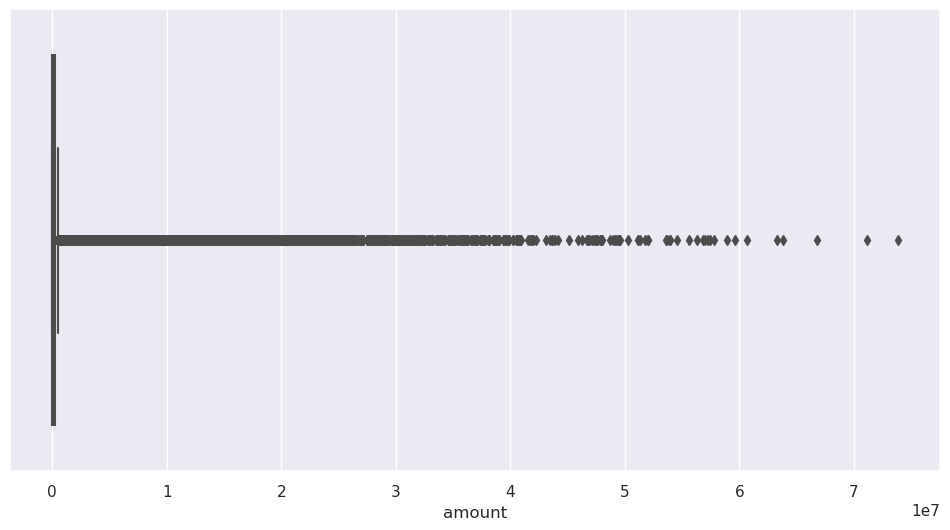

In [42]:
# boxplot
plt.subplots(figsize=(12,6))
sns.boxplot(num_attr['amount'])

In [43]:
 # check transactions with amount equal zero
aux1 = df1[df1['amount'] == 0]
aux2 = len(aux1)
aux2 

14

In [44]:
aux1

,step,type,amount,name_orig,oldbalance_org,newbalance_orig,name_dest,oldbalance_dest,newbalance_dest,is_fraud,is_flagged_fraud
1915449,212,CASH_OUT,0.000,C1510987794,0.000,0.000,C1696624817,0.000,0.000,1,0
2632541,279,CASH_OUT,0.000,C539112012,0.000,0.000,C1106468520,538547.630,538547.630,1,0
3894324,387,CASH_OUT,0.000,C1294472700,0.000,0.000,C1325541393,7970766.570,7970766.570,1,0
4197106,425,CASH_OUT,0.000,C832555372,0.000,0.000,C1462759334,76759.900,76759.900,1,0
4317595,554,CASH_OUT,0.000,C10965156,0.000,0.000,C1493336195,230289.660,230289.660,1,0
4343473,586,CASH_OUT,0.000,C1303719003,0.000,0.000,C900608348,1328472.860,1328472.860,1,0
4386189,617,CASH_OUT,0.000,C1971175979,0.000,0.000,C1352345416,0.000,0.000,1,0
4396844,646,CASH_OUT,0.000,C2060908932,0.000,0.000,C1587892888,0.000,0.000,1,0
4396846,646,CASH_OUT,0.000,C1997645312,0.000,0.000,C601248796,0.000,0.000,1,0
4406952,671,CASH_OUT,0.000,C1960007029,0.000,0.000,C459118517,27938.720,27938.720,1,0


#### 1.3.1.2. oldbalance_org feature analysis

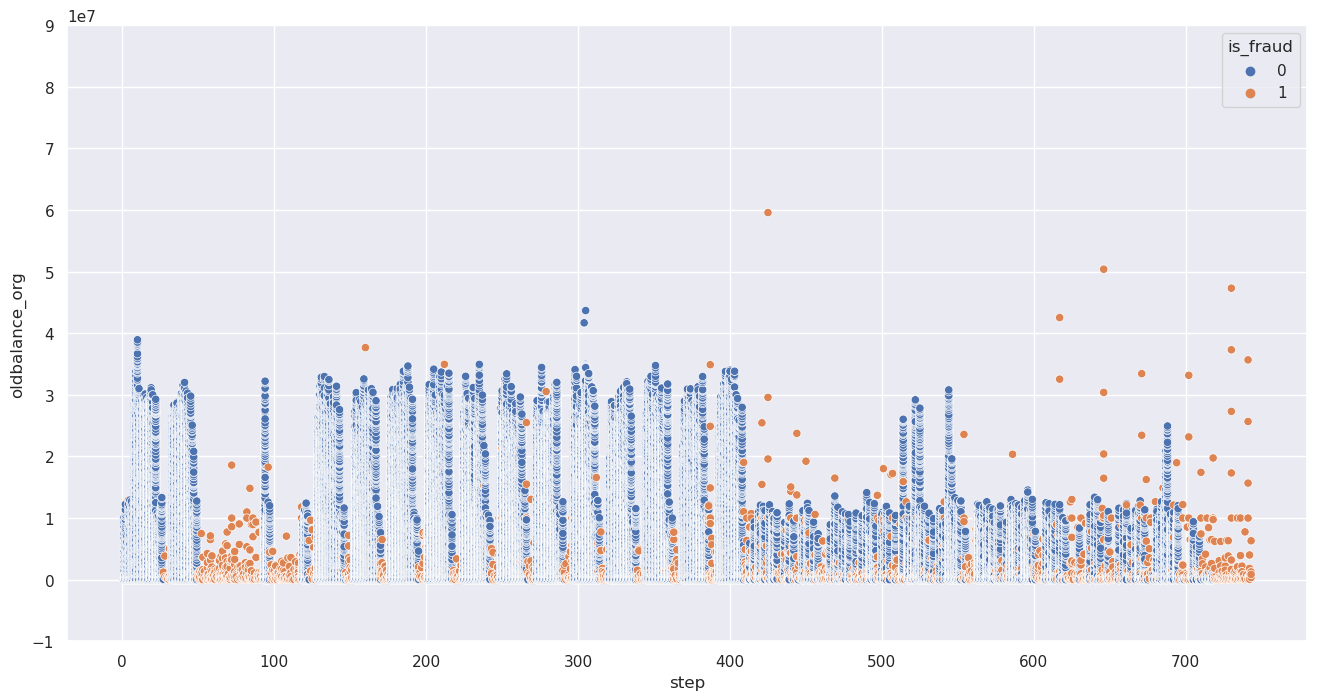

In [45]:
## # plot oldbalance_org scatter plot

# set up figure size
plt.subplots(figsize=(16,8))
sns.scatterplot(x='step', y='oldbalance_org', hue='is_fraud', data=num_attr)

# set y-axis labels
plt.yticks(np.arange(-1.e+07, 1.e+08, step=1.e+07));## 1.6.1.2. oldbalance_org feature analysis

<AxesSubplot:xlabel='oldbalance_org'>

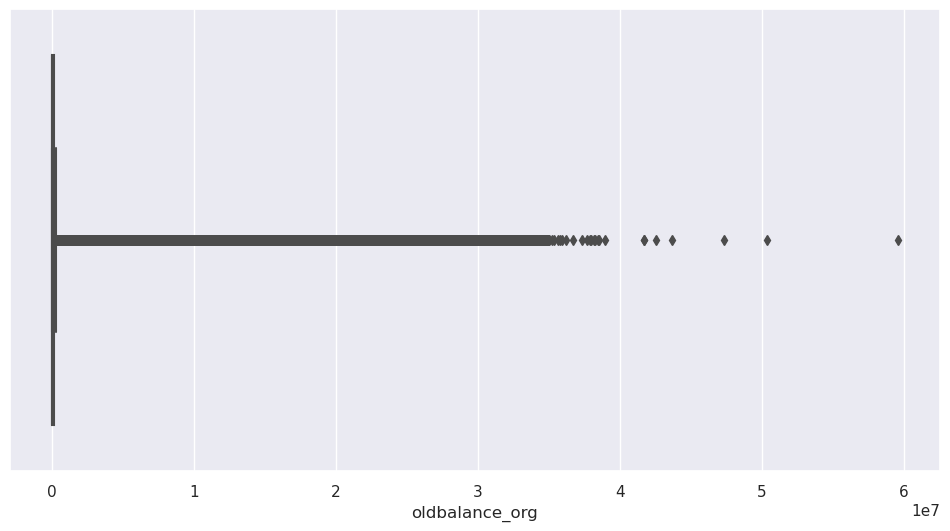

In [46]:
 # oldbalance_org boxplot
plt.subplots(figsize=(12,6))
sns.boxplot(num_attr['oldbalance_org'])

#### 1.3.1.3. newbalance_orig feature analysis

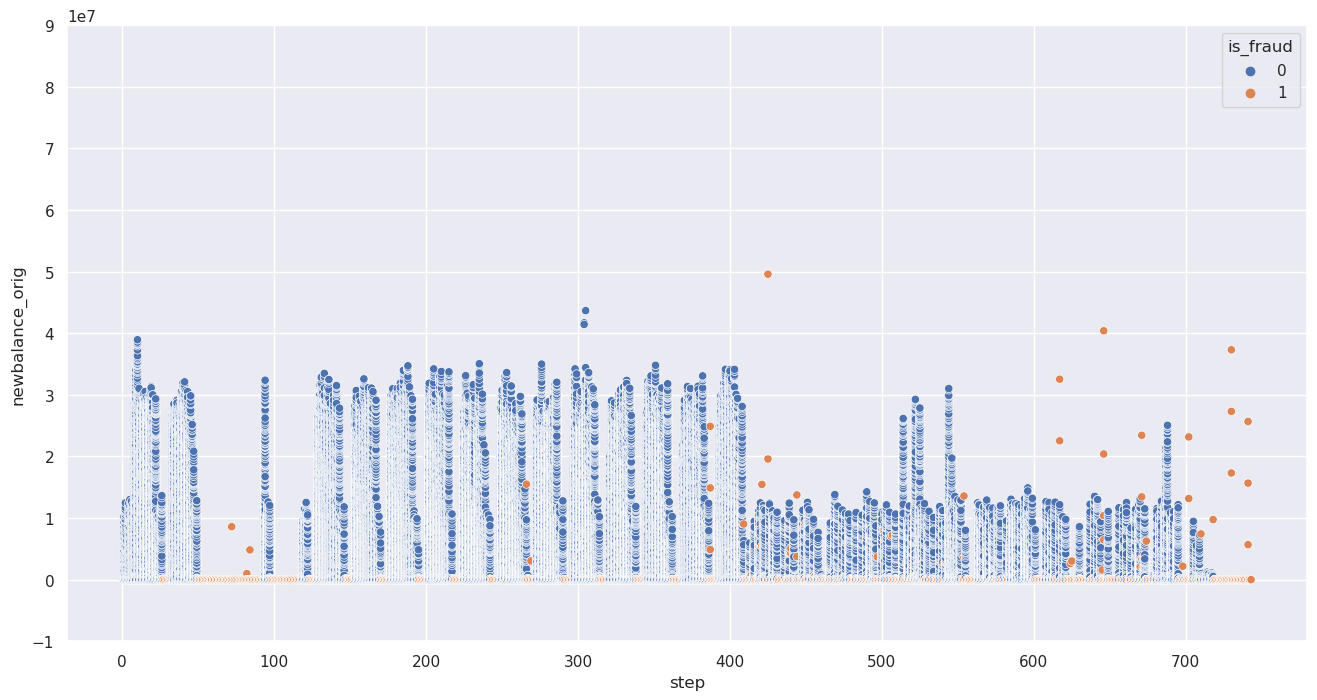

In [47]:
 # plot newbalance_orig scatter plot

# set up figure size
plt.subplots(figsize=(16,8))
sns.scatterplot(x='step', y='newbalance_orig', hue='is_fraud', data=num_attr)

# set y-axis labels
plt.yticks(np.arange(-1.e+07, 1.e+08, step=1.e+07));

<AxesSubplot:xlabel='newbalance_orig'>

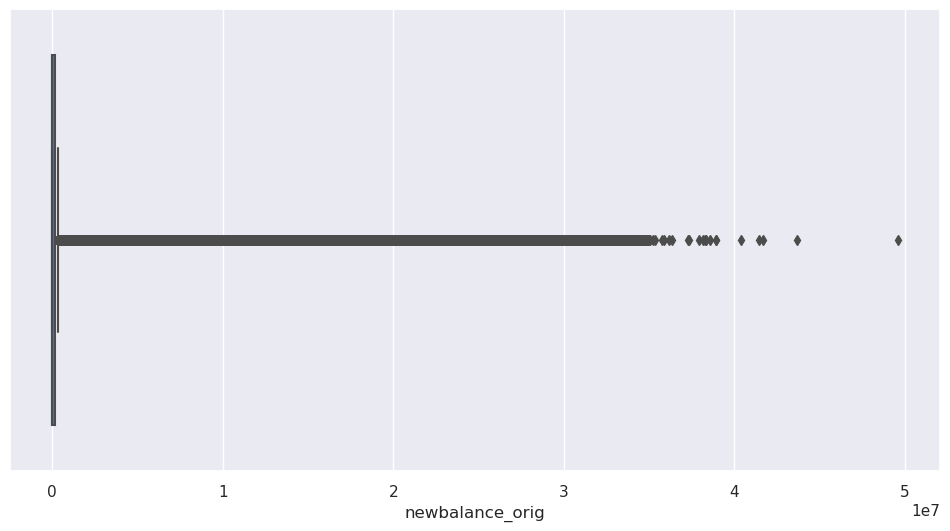

In [48]:
 # newbalance_orig boxplot
plt.subplots(figsize=(12,6))
sns.boxplot(num_attr['newbalance_orig'])

In [49]:
# check newbalance_orig value for fraudulent transactions
aux3 = df1[df1['is_fraud'] == 1]

# get the number of instances of newbalance_orig with value equal to zero
aux4 = aux3['newbalance_orig'].value_counts()[0]

# calculate the percentage of newbalance_orig with value equal to zero with respect to the total of frauds
newbal_per = np.round(((aux4 / len(aux3)) * 100), decimals=2)
newbal_per

98.11

 **Analisys:**
- The scatterplot shows that the majority of fraudulent transactions are placed in the newbalance_orig equal to zero.
- From all fraudulent transactions, 98.11% have newbalance_orig value equal to zero.

#### 1.3.1.4. oldbalance_dest feature analysis

<AxesSubplot:xlabel='step', ylabel='oldbalance_dest'>

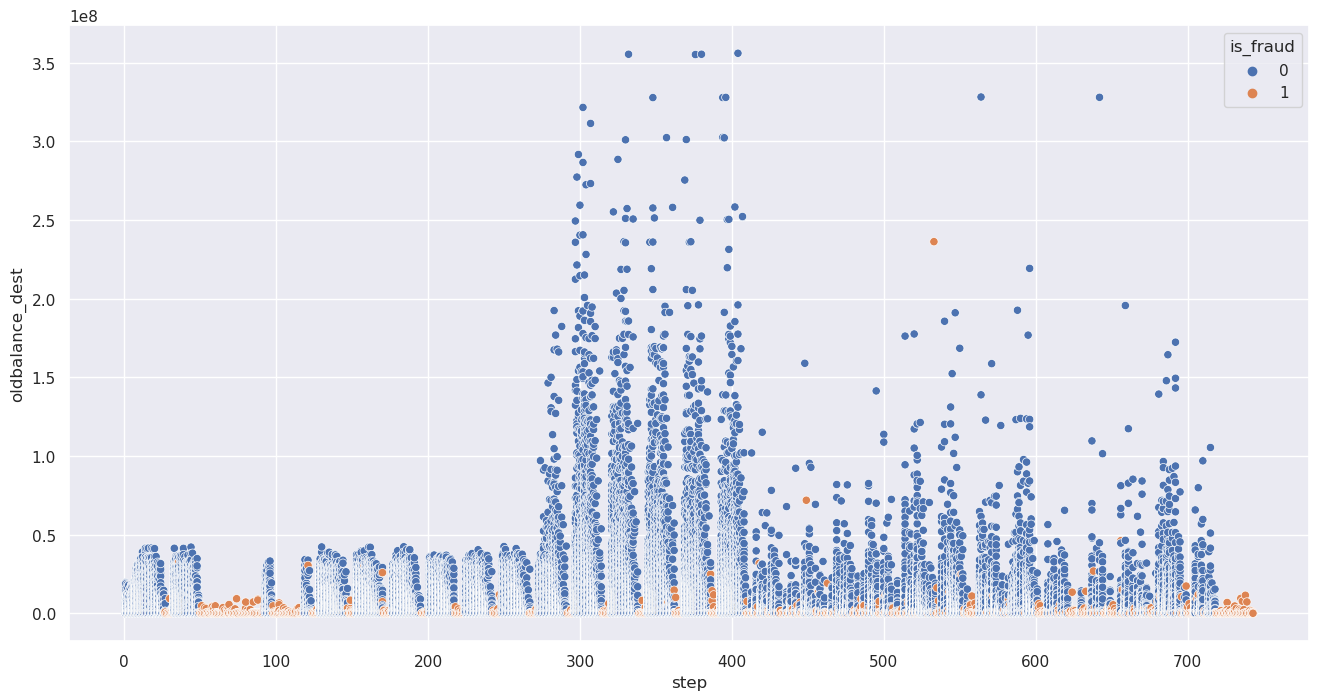

In [50]:
 # plot oldbalance_dest scatter plot

# set up figure size
plt.subplots(figsize=(16,8))
sns.scatterplot(x='step', y='oldbalance_dest', hue='is_fraud', data=num_attr)

<AxesSubplot:xlabel='oldbalance_dest'>

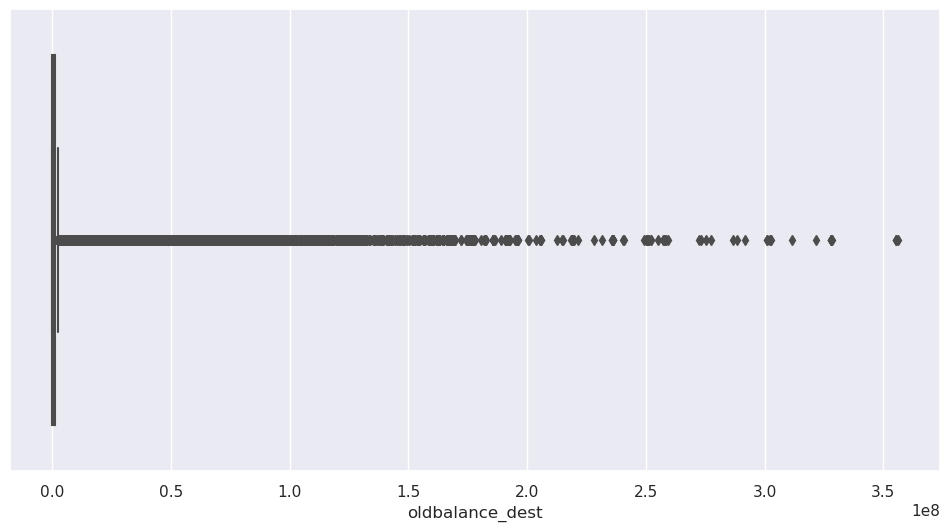

In [51]:
 # oldbalance_dest boxplot
plt.subplots(figsize=(12,6))
sns.boxplot(num_attr['oldbalance_dest'])

In [52]:
 # check oldbalance_dest value for fraudulent transactions
aux3 = df1[df1['is_fraud'] == 1]

# get the number of instances of oldbalance_dest with value equal to zero
aux5 = aux3['oldbalance_dest'].value_counts()[0]

# calculate the percentage of oldbalance_dest with value equal to zero with respect to the total of frauds
oldbal_per = np.round(((aux5 / len(aux3)) * 100), decimals=2)
oldbal_per

65.48

 **Analisys:**
- The scatterplot shows that the majority of fraudulent transactions are placed in the oldbalance_dest equal to zero.
- From all fraudulent transactions, 65.48% have oldbalance_dest value equal to zero.

#### 1.3.1.5. newbalance_dest feature analysis

<AxesSubplot:xlabel='step', ylabel='newbalance_dest'>

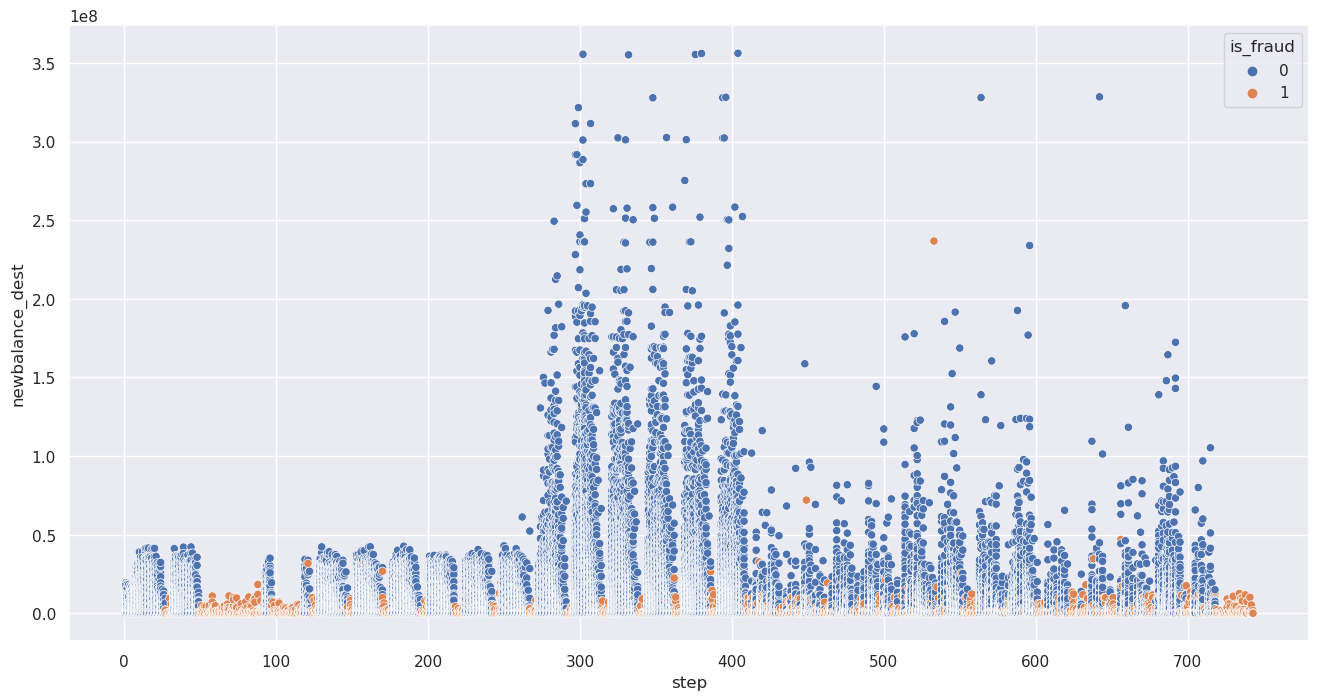

In [53]:
 # plot newbalance_dest scatter plot

# set up figure size
plt.subplots(figsize=(16,8))
sns.scatterplot(x='step', y='newbalance_dest', hue='is_fraud', data=num_attr)

<AxesSubplot:xlabel='newbalance_dest'>

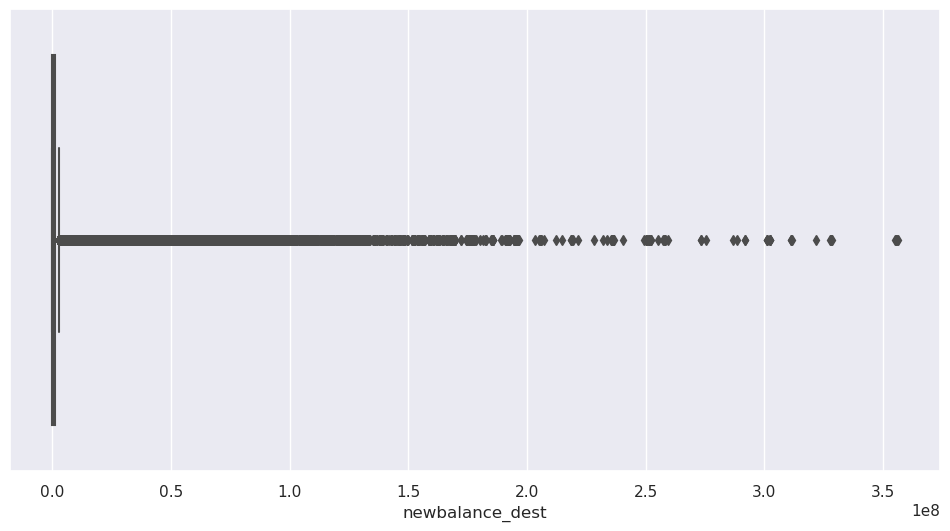

In [54]:
# newbalance_dest boxplot
plt.subplots(figsize=(12,6))
sns.boxplot(num_attr['newbalance_dest'])

In [55]:
 # check newbalance_dest value for fraudulent transactions

# get the number of instances of newbalance_dest with value equal to zero
aux6 = aux3['newbalance_dest'].value_counts()[0]

# calculate the percentage of newbalance_dest with value equal to zero with respect to the total of frauds
newbal_per = np.round(((aux6 / len(aux3)) * 100), decimals=2)
newbal_per

49.75

 **Analisys:**
- The scatterplot shows that most of fraudulent transactions are placed in the newbalance_dest equal to zero.
- From all fraudulent transactions, 49.75% have newbalance_dest value equal to zero.

## 1.3.2. Categorical Attributes

In [56]:
# select categorical attributes
cat_attr = df1.select_dtypes(exclude=['int16', 'float64'])

In [57]:
cat_attr.describe() 

,type,name_orig,name_dest
count,4453587,4453587,4453587
unique,5,4448972,2035197
top,CASH_OUT,C1677795071,C985934102
freq,1565597,3,86


In [58]:
# Check unique entries of categorical attributes
cat_attr.apply( lambda x: x.unique().shape[0] )

type               5
name_orig    4448972
name_dest    2035197
dtype: int64

In [59]:
# check type feature
type_counts = cat_attr['type'].value_counts()
type_counts

CASH_OUT    1565597
PAYMENT     1506744
CASH_IN      979072
TRANSFER     373080
DEBIT         29094
Name: type, dtype: int64

In [60]:
 # create type feature percentage dataframe
# list of values and names from type_counts
value_list = []
name_list = []
for i in range(len(type_counts)):
    percent = np.round(((type_counts[i] / len(cat_attr)) * 100), decimals=2)
    value_list.append(percent)
    name_list.append(type_counts.index[i])

# create dataframe
type_df = pd.DataFrame({'percentage_%': value_list}, index=name_list)
type_df

,percentage_%
CASH_OUT,35.150
PAYMENT,33.830
CASH_IN,21.980
TRANSFER,8.380
DEBIT,0.650


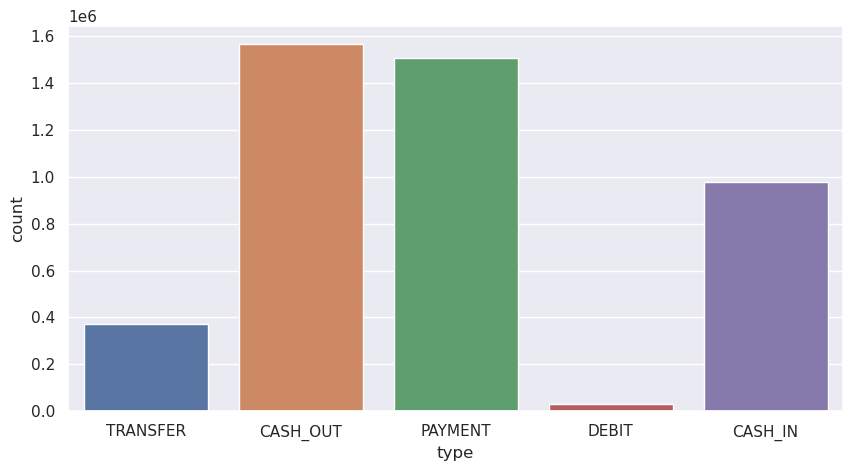

In [61]:
# plot type feature
plt.subplots(figsize=(10,5))
sns.countplot(x='type', data=cat_attr);

<AxesSubplot:xlabel='type', ylabel='amount'>

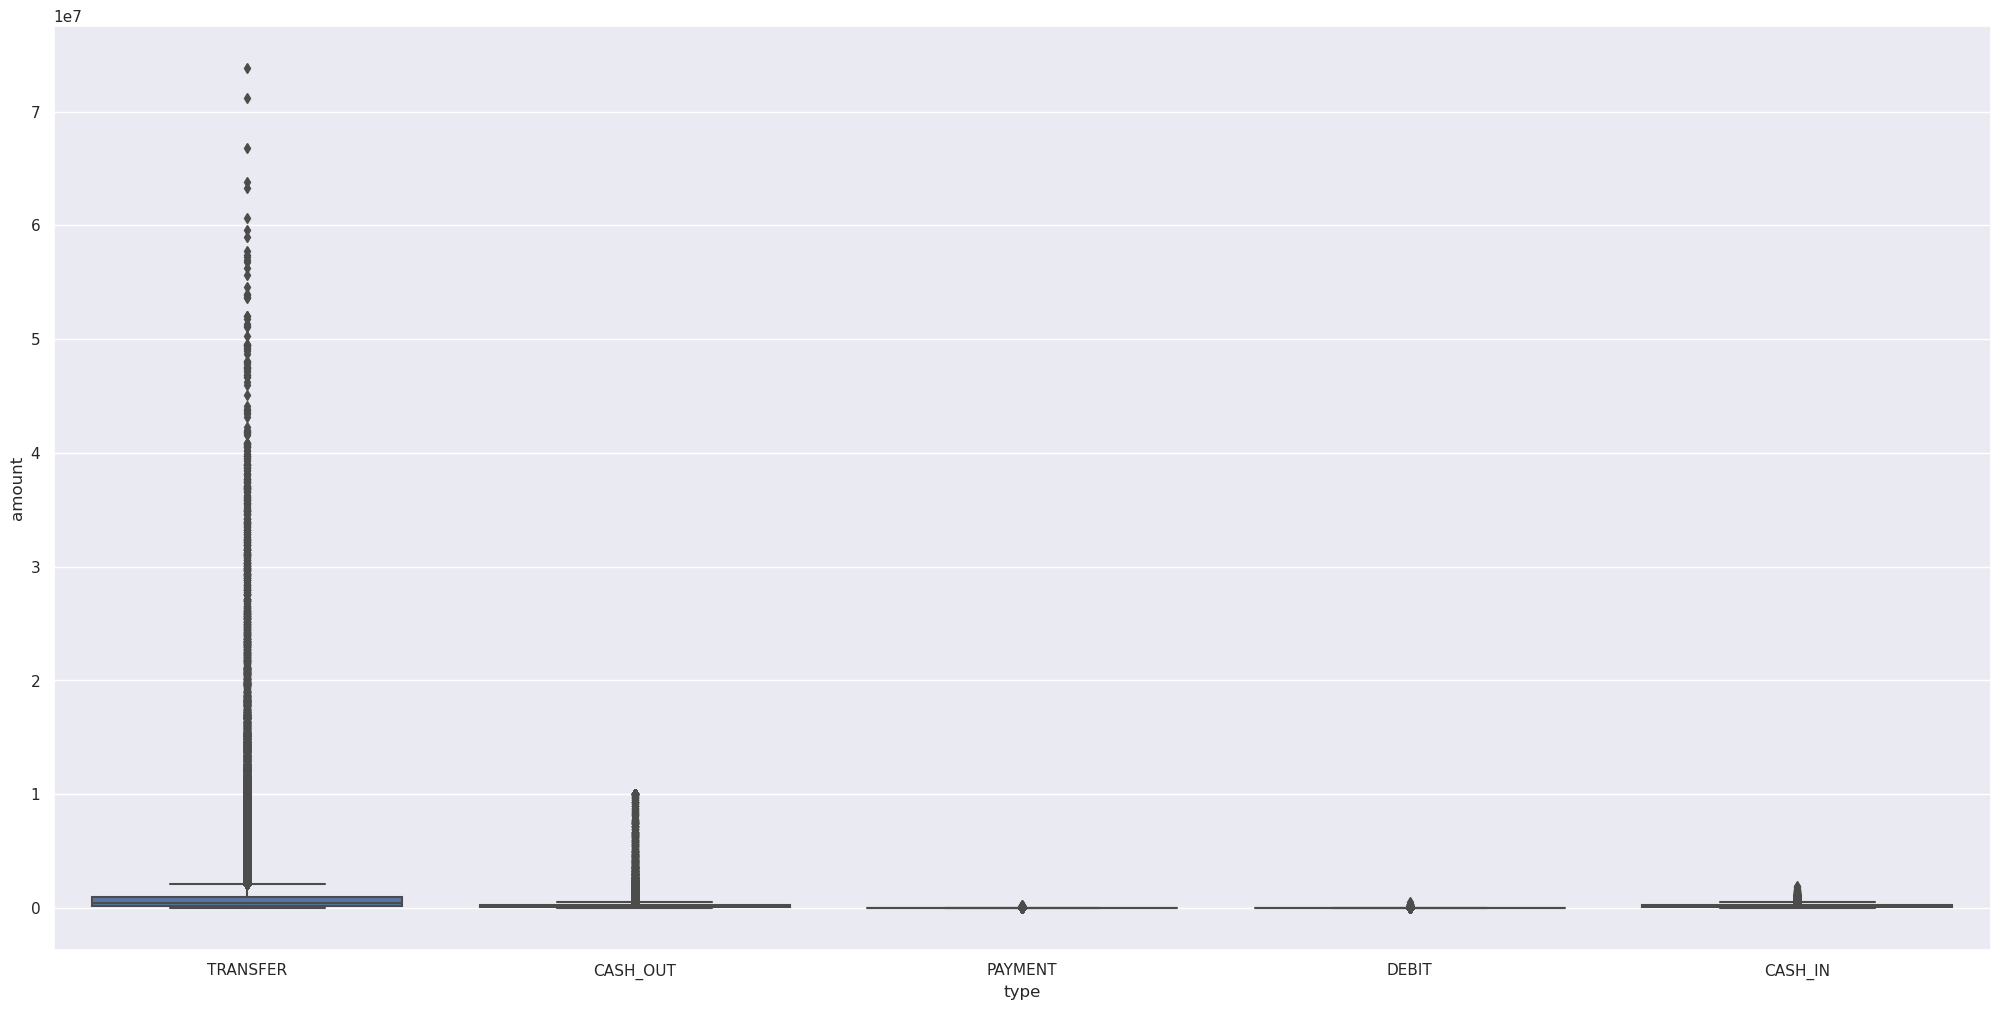

In [62]:
sns.boxplot(x='type', y='amount', data=df1) 

- Although the boxplot has not a good resolution due to amount values, it shows that transfer type has the biggest range of amounts.

In [63]:
cat_attr['name_dest'].value_counts() 

C985934102     86
C1286084959    78
C665576141     74
C1789550256    74
C1590550415    72
               ..
M730141676      1
M1843464772     1
C1278993047     1
M208334503      1
C2080388513     1
Name: name_dest, Length: 2035197, dtype: int64

- Some recipient of transaction participate on transaction more than 86 times.

In [64]:
cat_attr['name_orig'].value_counts() 

C1677795071    3
C1976208114    3
C363736674     3
C1065307291    3
C1784010646    3
              ..
C280084872     1
C884044387     1
C1452248792    1
C1560452043    1
C1685995037    1
Name: name_orig, Length: 4448972, dtype: int64

- Some customers made transactions more than once.

## 1.4. Data Description Summary

 **Data Description Summary:**
        **1. Balances**
- **None of the balances have negative numbers.**
- The intial balance before the transaction (oldbalance_org) ranges from 0 to aprox. 59 Million. Mean = 834,757. **25% of the observations are equal to zero**. 75% of the observations are up to the value of 107,429.
- The new balance after the transaction (newbalance_orig) ranges from 0 to more than 49 Million. Mean = 855,975. **50% of the observations are equal to zero**. 75% of the observations are up to the value of 144,412.
- The initial balance recipient before the transaction (oldbalance_dest) **ranges from 0 to more than 356 Million**. Mean = 1,100,704. 25% of the observations are equal to zero. 75% of the observations are up to the value of 943,372.
- The new balance recipient after the transaction (newbalance_dest) **ranges from zero to more than 356 Million**. Mean = 1,225,085. 25% of the observations are equal to zero - it can be either from merchant or from fraudulent agent behaviour (cashing out of the system). 75% of the observations are up to the value of 1,112,270.

**2. Transaction Amount**
- Transaction amount ranges from 0 to more than 92 Million, Mean = 179,939. **The minimum value is equal to zero.**
- **The maximum amount value (aprox. 92 Million) is greater than the maximum value of the initial balance before the transaction (aprox. 59 Million).**
- Between steps 50 and 75 seems that there are few / not transactions;
- After step 400 the frequency of transactions decreases significantly.
- **Fraudulent transaction amounts are up to the value of 10 million. There is not fraud transaction above 10 million.**
- 11 instances have amount transaction equal to zero, all of them with cash out type and labeled as fraud.
- There are instances with amount higher than oldbalance_org.

**3. fraud label**
- Only 0.13% of the observations are labeled as fraud

**From all fraudulent transactions:**
- **97.91% have newbalance_orig value equal to zero.**
- **65.19% have oldbalance_dest value equal to zero.**
- **49.9% have newbalance_dest value equal to zero.**

**4. is_flagged_fraud label**
- 14 instances are labeled as is_flagged_fraud. That represents only 0.03% of the instances.

**5. Type feature**
- 68% of the transactions are cash out and payment types.
- Almost 22% of transactions are cash in type, 8% are transfer type and only 0.65% are debit type.
- The transfer type has the biggest transaction amount range.

**6. Name_dest, name_orig features**
- Some recipient of transaction participate on transaction more than 80 times.
- Some customers made transactions more than once.

# 2.0. Feature Engineering

In [65]:
 # open previously saved training set
df2 = df1.copy()
df2.head()

,step,type,amount,name_orig,oldbalance_org,newbalance_orig,name_dest,oldbalance_dest,newbalance_dest,is_fraud,is_flagged_fraud
0,1,TRANSFER,181.000,C1305486145,181.000,0.000,C553264065,0.000,0.000,1,0
1,1,CASH_OUT,181.000,C840083671,181.000,0.000,C38997010,21182.000,0.000,1,0
2,1,PAYMENT,7817.710,C90045638,53860.000,46042.290,M573487274,0.000,0.000,0,0
3,1,PAYMENT,7107.770,C154988899,183195.000,176087.230,M408069119,0.000,0.000,0,0
4,1,PAYMENT,7861.640,C1912850431,176087.230,168225.590,M633326333,0.000,0.000,0,0


- As previously checked in the data description, **some amount transactions are higher than the origin banlance before the transaction. Also, there are amount instances equal to zero.Theoretically, the difference between the origin balance before and after the transaction should be equal to the transaction amount.** Therefore, a new feature will be created to check this.

- The same is true for the destination balance: **theoretically, the difference between the destination balance after and before the transaction should be equal to the transaction amount.** Therefore, a new feature will be created to check this.

- As stated above in the features description, the balance destination information for merchant customers is not available. Therefore, a new feature will be created to differentiate such customers to the ordinary ones.

- A new time feature can be created based on the step information to determine the day in which the transactions happened, in order to ease the analysis.

In [67]:
 # create origin balance difference feature
df2['diff_orig'] = df2['oldbalance_org'] - df2['amount'] - df2['newbalance_orig']

# create destination balance difference feature
df2['diff_dest'] = df2['oldbalance_dest'] + df2['amount'] - df2['newbalance_dest']

In [68]:
df2.head()

,step,type,amount,name_orig,oldbalance_org,newbalance_orig,name_dest,oldbalance_dest,newbalance_dest,is_fraud,is_flagged_fraud,diff_orig,diff_dest
0,1,TRANSFER,181.000,C1305486145,181.000,0.000,C553264065,0.000,0.000,1,0,0.000,181.000
1,1,CASH_OUT,181.000,C840083671,181.000,0.000,C38997010,21182.000,0.000,1,0,0.000,21363.000
2,1,PAYMENT,7817.710,C90045638,53860.000,46042.290,M573487274,0.000,0.000,0,0,0.000,7817.710
3,1,PAYMENT,7107.770,C154988899,183195.000,176087.230,M408069119,0.000,0.000,0,0,0.000,7107.770
4,1,PAYMENT,7861.640,C1912850431,176087.230,168225.590,M633326333,0.000,0.000,0,0,0.000,7861.640


In [69]:
# check if name_orig has merchant customer
df2['name_orig'].str.contains('M').sum()

0

In [70]:
 # check merchant customer on name_dest
df2['name_dest'].str.contains('M').sum()

1506744

- name_orig does not have merchant customer. Therefore, it is not necessary to create a new feature;
- name_dest has 430,261 instances with merchant customer. Therefore, a new feature will be created.

In [71]:
# create merchant_dest feature
df2['merchant_dest'] = df2.apply(lambda x: 1 if 'M' in x['name_dest'] else 0, axis=1)
df2.head()

,step,type,amount,name_orig,oldbalance_org,newbalance_orig,name_dest,oldbalance_dest,newbalance_dest,is_fraud,is_flagged_fraud,diff_orig,diff_dest,merchant_dest
0,1,TRANSFER,181.000,C1305486145,181.000,0.000,C553264065,0.000,0.000,1,0,0.000,181.000,0
1,1,CASH_OUT,181.000,C840083671,181.000,0.000,C38997010,21182.000,0.000,1,0,0.000,21363.000,0
2,1,PAYMENT,7817.710,C90045638,53860.000,46042.290,M573487274,0.000,0.000,0,0,0.000,7817.710,1
3,1,PAYMENT,7107.770,C154988899,183195.000,176087.230,M408069119,0.000,0.000,0,0,0.000,7107.770,1
4,1,PAYMENT,7861.640,C1912850431,176087.230,168225.590,M633326333,0.000,0.000,0,0,0.000,7861.640,1


In [72]:
 # create day feature
df2['day'] = df2.apply(lambda x: (np.ceil(x['step'] / 24)).astype(int), axis=1)
df2.head()

,step,type,amount,name_orig,oldbalance_org,newbalance_orig,name_dest,oldbalance_dest,newbalance_dest,is_fraud,is_flagged_fraud,diff_orig,diff_dest,merchant_dest,day
0,1,TRANSFER,181.000,C1305486145,181.000,0.000,C553264065,0.000,0.000,1,0,0.000,181.000,0,1
1,1,CASH_OUT,181.000,C840083671,181.000,0.000,C38997010,21182.000,0.000,1,0,0.000,21363.000,0,1
2,1,PAYMENT,7817.710,C90045638,53860.000,46042.290,M573487274,0.000,0.000,0,0,0.000,7817.710,1,1
3,1,PAYMENT,7107.770,C154988899,183195.000,176087.230,M408069119,0.000,0.000,0,0,0.000,7107.770,1,1
4,1,PAYMENT,7861.640,C1912850431,176087.230,168225.590,M633326333,0.000,0.000,0,0,0.000,7861.640,1,1


In [73]:
df2.tail()

,step,type,amount,name_orig,oldbalance_org,newbalance_orig,name_dest,oldbalance_dest,newbalance_dest,is_fraud,is_flagged_fraud,diff_orig,diff_dest,merchant_dest,day
4453582,743,TRANSFER,1258818.820,C1531301470,1258818.820,0.000,C1470998563,0.000,0.000,1,0,0.000,1258818.820,0,31
4453583,743,CASH_OUT,1258818.820,C1436118706,1258818.820,0.000,C1240760502,503464.500,1762283.330,1,0,0.000,-0.010,0,31
4453584,743,CASH_OUT,339682.130,C786484425,339682.130,0.000,C776919290,0.000,339682.130,1,0,0.000,0.000,0,31
4453585,743,TRANSFER,6311409.280,C1529008245,6311409.280,0.000,C1881841831,0.000,0.000,1,0,0.000,6311409.280,0,31
4453586,743,TRANSFER,850002.520,C1685995037,850002.520,0.000,C2080388513,0.000,0.000,1,0,0.000,850002.520,0,31


In [74]:
# df2 columns
df2.columns

Index(['step', 'type', 'amount', 'name_orig', 'oldbalance_org',
       'newbalance_orig', 'name_dest', 'oldbalance_dest', 'newbalance_dest',
       'is_fraud', 'is_flagged_fraud', 'diff_orig', 'diff_dest',
       'merchant_dest', 'day'],
      dtype='object')

In [75]:
 # reorder columns
df2 = df2[['step', 'day', 'type', 'name_orig', 'amount', 'oldbalance_org',
       'newbalance_orig', 'diff_orig', 'name_dest', 'merchant_dest', 
       'oldbalance_dest', 'newbalance_dest', 'diff_dest',
       'is_fraud', 'is_flagged_fraud']]

df2.tail()

,step,day,type,name_orig,amount,oldbalance_org,newbalance_orig,diff_orig,name_dest,merchant_dest,oldbalance_dest,newbalance_dest,diff_dest,is_fraud,is_flagged_fraud
4453582,743,31,TRANSFER,C1531301470,1258818.820,1258818.820,0.000,0.000,C1470998563,0,0.000,0.000,1258818.820,1,0
4453583,743,31,CASH_OUT,C1436118706,1258818.820,1258818.820,0.000,0.000,C1240760502,0,503464.500,1762283.330,-0.010,1,0
4453584,743,31,CASH_OUT,C786484425,339682.130,339682.130,0.000,0.000,C776919290,0,0.000,339682.130,0.000,1,0
4453585,743,31,TRANSFER,C1529008245,6311409.280,6311409.280,0.000,0.000,C1881841831,0,0.000,0.000,6311409.280,1,0
4453586,743,31,TRANSFER,C1685995037,850002.520,850002.520,0.000,0.000,C2080388513,0,0.000,0.000,850002.520,1,0


# 3.0. Variables Filtering

In [76]:
df3 = df2.copy()

## 3.1. Lines Filtering

In [77]:
# Remove outliers from amount feature
df3 = df3[df3['amount'] < 20e6]
df3.shape

# Remove oldbalance_dest outliers
df3 = df3[df3['oldbalance_dest'] < 5e7]
df3.shape

# Remove newbalance_dest outliers
df3 = df3[df3['newbalance_dest'] < 5e7]

## 3.2. Save training set

In [78]:
 # save train set for future notebook work
df3.to_csv('../data/processed/df3_v02.csv', index=False)

# 4.0. EDA - Exploratory Data Analysis

In [79]:
 # open previously saved training set
df4 = pd.read_csv('../data/processed/df3_v02.csv')

## 4.1. Univariate Analysis**

In [80]:
df4.sample(5)

,step,day,type,name_orig,amount,oldbalance_org,newbalance_orig,diff_orig,name_dest,merchant_dest,oldbalance_dest,newbalance_dest,diff_dest,is_fraud,is_flagged_fraud
2460196,259,11,PAYMENT,C866665133,7781.820,99900.000,92118.180,0.000,M35535850,1,0.000,0.000,7781.820,0,0
369321,20,1,CASH_OUT,C683142114,2072.830,9152.000,7079.170,0.000,C1806489162,0,237714.990,239787.820,-0.000,0,0
2874855,302,13,CASH_IN,C1863437506,171337.460,4842359.750,5013697.210,-342674.920,C1501491300,0,1025534.480,854197.010,342674.930,0,0
1409855,180,8,CASH_IN,C671016819,66935.340,14143180.920,14210116.260,-133870.680,C1812040076,0,269503.550,202568.210,133870.680,0,0
1315276,164,7,TRANSFER,C587504429,367004.300,0.000,0.000,-367004.300,C589311040,0,2094401.180,2461405.470,0.010,0,0


### 4.1.1. Target Variable

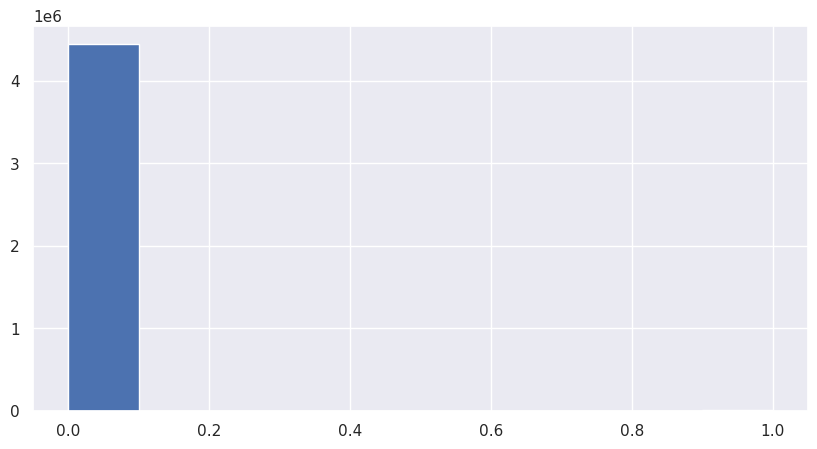

In [81]:
# plot target variable
df4['is_fraud'].hist(figsize=(10,5));

In [83]:
 # check is_fraud labels proportion
df4['is_fraud'].value_counts(normalize=True)

0   0.999
1   0.001
Name: is_fraud, dtype: float64

- The graph is not visually clear regarding is_fraud = 1 due to its low proportion (0.1%).
- The is_fraud feature is better visualized with respect to the other features. The graphs are shown below in the bivariate analysis.
 
- Plot fraudulent transactions per day

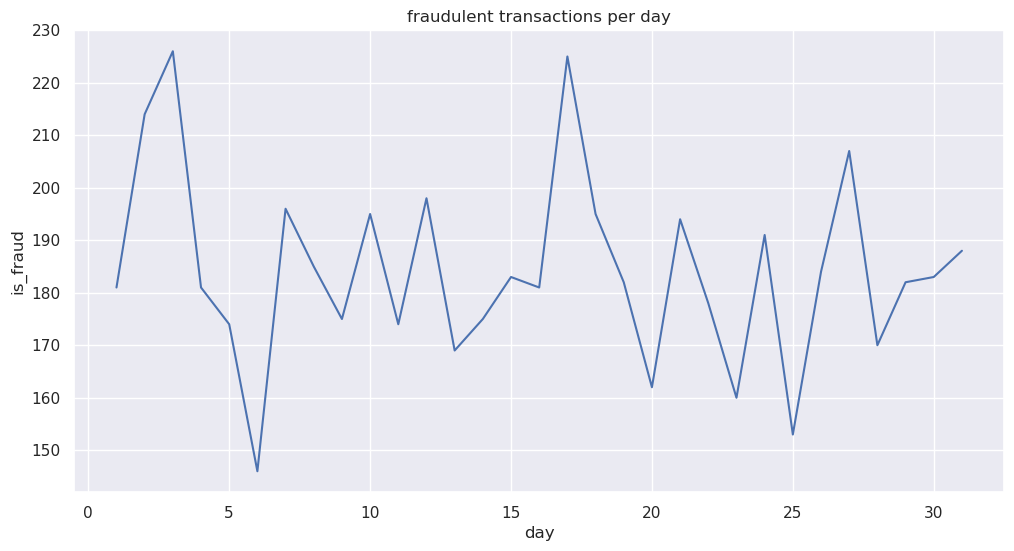

In [84]:
 # plot fraudulent transactions per day
aux1 = df4[['day', 'is_fraud']].groupby('day').sum().reset_index()

# set up figure size
plt.subplots(figsize=(12,6))
sns.lineplot(x='day', y='is_fraud', data=aux1).set_title('fraudulent transactions per day');